In [1]:
%matplotlib inline
import os, time, random, json
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.core.display import Image, display
from tqdm import tnrange, tqdm_notebook
import kornia

In [2]:
import nltk
nltk.download('punkt')

# test
txt = 'cat dog women run'
print([word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(txt)) if pos[0] == 'N'])

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['cat', 'dog', 'women']


In [3]:
def is_noun(word):
    return nltk.pos_tag([word])[0][1][0] == 'N'

print(is_noun('the'), is_noun('dog'), is_noun('running'))

False True False


In [4]:
vector_size = 100
names = None
data = None

try:
    data = np.load('globe_%i_nouns.npy'%vector_size)
    with open('globe_%i_nouns.json'%vector_size, 'r') as out:
        names = json.load(out)
    print('Loaded from disk')
except:
    names = []
    data = []
    print('Parsing file')
    with open('glove.6B.%id.txt'%vector_size) as f:
        for i, line in enumerate(f):
            line = line.split()
            name = line[0]
            assert len(line) == vector_size+1
            if not name.isalpha() or len(name) < 3:
                continue
            if not is_noun(name):
                print(name)
                continue
            names.append(name)
            vector = []
            for j in range(vector_size):
                vector.append(float(line[j+1]))
            data.append(vector)

    data = np.array(data, dtype='float32')
    np.save('globe_%i_nouns.npy'%vector_size, data)
    with open('globe_%i_nouns.json'%vector_size, 'w') as out:
        json.dump(names, out)

data /= 3
assert len(data) == len(names)
print(len(data))
print(data.min(), data.max())

Loaded from disk
298196
-1.3555332 1.1916667


In [5]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128, vector_size=100):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(vector_size, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = self.deconv1_1(input)        
        x = self.deconv1_1_bn(x)
        x = F.relu(x)
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = self.deconv4(x)
        x = torch.tanh(x)
        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128, vector_size=100):
        super(discriminator, self).__init__()
        self.d = d
        self.conv1_1 = nn.Conv2d(1, int(d/2), 4, 2, 1)
        self.conv2 = nn.Conv2d(int(d/2), d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.fc1 = nn.Linear(d*4*4*4, 512)
        self.fc2 = nn.Linear(512, vector_size)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = x.view(self.d, self.d*4*4*4)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.tanh(x)
        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [6]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=1)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [7]:
# def show_images(images, path='result.png', rows=8):
#     save_image(images, path, nrow=rows, padding=1, pad_value=1.0, scale_each=False, normalize=False)
#     display(Image(path))
    
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    G.eval()
    test_images = G(fixed_z, fixed_x)
    test_images = (test_images.cpu() + 1) * 0.5
    G.train()
    test_images = test_images[:100].data.view(100, 1, 32, 32)
    save_image(test_images, path, nrow=10, padding=1, pad_value=1, scale_each=False, normalize=False)
    display(Image(path))

In [8]:
def noise(input):
    rand = (torch.rand(*input.shape) - 0.5) * 2
    input = torch.clamp(input + rand.cuda(), 0, 1)

    r = 30
    angles = torch.tensor([-r + random.random()*2*r for _ in range(input.shape[0])]).cuda()
    input = kornia.geometry.transform.rotate(input, angles)

    d = 6
    x = [[( float(int(random.uniform(-d, d)))), float(int(random.uniform(-d, d)))] for _ in range(input.shape[0]) ]
    t = torch.tensor( x ).cuda()
    input = kornia.geometry.transform.translate(input, t)
    return input

In [9]:
import shutil, os
def reset_folder_contents(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

In [10]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 12

# fixed noise & label
top_n = 500
X = torch.from_numpy(data[:top_n]).cuda()
X.unsqueeze_(2)
X.unsqueeze_(3)
None

In [11]:
fixed_z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()

# idxs = np.random.randint(top_n, size=(batch_size))
# idxs = np.arange(batch_size)
idxs = np.arange(top_n)
np.random.shuffle(idxs)
idxs = idxs[:batch_size]
fixed_x = X[idxs]

training start!
Starting 0



[1/12] - ptime: 62.11, loss_d: 0.02118477, loss_g: 0.02125874


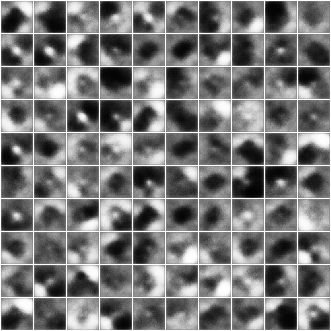

Starting 1



[2/12] - ptime: 62.15, loss_d: 0.01503843, loss_g: 0.01529583


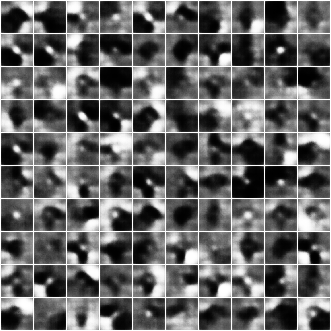

Starting 2


In [ ]:

# network
G = generator(128, vector_size=vector_size)
D = discriminator(128, vector_size=vector_size)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

MSE_loss = nn.MSELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
root = './word2vec_results/'
reset_folder_contents(root)

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

print('training start!')
start_time = time.time()

for epoch in range(train_epoch):
    print('Starting', epoch)
    D_losses = []
    G_losses = []

    # learning rate decay
    if (epoch+1) in [6, 10, 14]:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    epoch_start_time = time.time()
    
    for i in tqdm_notebook(range(200)):
        #----------------------
        # train discriminator D
        #----------------------
        D.zero_grad()
        x = X[ np.random.randint(top_n, size=(batch_size)) ]
        z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()

        # Evaluate networks.
        G_result = G(z, x)
        D_result = D(noise(G_result))
        
        # The descriminator loss is simply the reconstruction loss.
        D_loss = MSE_loss(D_result.squeeze(), x.squeeze())
        
        D_loss.backward()
        D_optimizer.step()
        D_losses.append(D_loss.item())
        
        #----------------------
        # train generator G
        #----------------------
        G.zero_grad()
        x = X[ np.random.randint(top_n, size=(batch_size)) ]
        z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
    
        # Evaluate the networks
        G_result = G(z, x)
        D_result = D(noise(G_result)).squeeze()

        tv_loss = ( torch.sum(torch.abs(G_result[:, :, :, :-1] - G_result[:, :, :, 1:])) + 
                    torch.sum(torch.abs(G_result[:, :, :-1, :] - G_result[:, :, 1:, :])))
        
        # The generator loss is the reconstruction loss and some normalization.
        G_loss = MSE_loss(D_result, x.squeeze()) + 1e-8*tv_loss
        
        G_loss.backward()
        G_optimizer.step()
        G_losses.append(G_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.8f, loss_g: %.8f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    fixed_path = os.path.join(root, str(epoch + 1) + '.png')
    show_result((epoch+1), show=True, path=fixed_path)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)


In [ ]:
# print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
# print("Training finish!... save training results")
torch.save(G.state_dict(), root + 'generator_param.pkl')
torch.save(D.state_dict(), root + 'discriminator_param.pkl')

with open(root + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

images = []
for e in range(train_epoch):
    img_name = root + str(e + 1) + '.png'
    if not os.path.exists(img_name):
        break
    images.append(imageio.imread(img_name))
    
imageio.mimsave(root + 'generation_animation.gif', images, fps=5)
with open(root + 'generation_animation.gif','rb') as f:
    display(Image(data=f.read(), format='png'))


In [ ]:
show_train_hist(train_hist, show=True, save=True, path=root + 'train_hist.png')

In [ ]:
a = np.random.randint(top_n, size=(batch_size))
x = torch.from_numpy(data[a])
x.unsqueeze_(2)
x.unsqueeze_(3)
x = x.cuda()
G_result = G(fixed_z, x)
D_result = D(G_result,0)

In [ ]:
def closest_word(vector_a):
    min_d = None
    min_i = None
    
    for i, vector_b in enumerate(data[:top_n]):        
        dist = np.linalg.norm(vector_a - vector_b)
        if min_d is None or dist < min_d:
            min_i = i
            min_d = dist
            
    return names[min_i] 

In [ ]:
for i, index in enumerate(a):
    result_array = D_result[i].detach().cpu().numpy()
    print(names[index], closest_word(result_array))
#     print()

In [ ]:
test_images = (G_result.cpu() + 1) * 0.5
test_images = test_images[:100].data.view(100, 1, 32, 32)
# test_images = 1 - test_images
save_image(test_images, './test.png', nrow=10, padding=1, pad_value=1, scale_each=True, normalize=True)
display(Image('./test.png'))

In [ ]:
names.index('queen')